# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1Mk06KpqIq0JT3CtmnTiZWm56tNqApUNy?usp=sharing

In [74]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [75]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [76]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [77]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [78]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [79]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [80]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [81]:
# minimum, maximum, and average value 
columns = ["age", "yredu", "capgain", "caploss", "workhr"]
for category in columns:
  print(category)
  print('min value of',category,":",(df[category]).min())
  print('max value of',category,":", (df[category]).max())
  print('avg value of',category,":", (df[category]).mean())

age
min value of age : 17
max value of age : 90
avg value of age : 38.58164675532078
yredu
min value of yredu : 1
max value of yredu : 16
avg value of yredu : 10.0806793403151
capgain
min value of capgain : 0
max value of capgain : 99999
avg value of capgain : 1077.6488437087312
caploss
min value of caploss : 0
max value of caploss : 4356
avg value of caploss : 87.303829734959
workhr
min value of workhr : 1
max value of workhr : 99
avg value of workhr : 40.437455852092995


In [82]:
# normalize each of the features so that their values are always between 0 and 1
for category in columns:
  df[category] = (df[category]-(df[category]).min()) / ((df[category]).max() - (df[category]).min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [83]:
# hint: you can do something like this in pandas
num_male = sum(df["sex"] == " Male")
num_female = sum(df["sex"] == " Female")

print('The % of males is:',100*num_male/(num_male+num_female), '%')
print('The % of females is:',100*num_female/(num_male+num_female), '%')

The % of males is: 66.92054912318417 %
The % of females is: 33.07945087681582 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [84]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [85]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [86]:
print("number of records is", len(df))
print("number of records with missing features is", len(df_with_missing))
print("percentage of records removed is", (len(df_with_missing)/len(df))*100, "%")

number of records is 32561
number of records with missing features is 1843
percentage of records removed is 5.660145572924664 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [87]:
print("the possible values of the feature work in df_not_missing are:")
print(set(df_not_missing["work"])) 

the possible values of the feature work in df_not_missing are:
{' Without-pay', ' Private', ' Self-emp-inc', ' State-gov', ' Federal-gov', ' Self-emp-not-inc', ' Local-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [88]:
data = pd.get_dummies(df_not_missing)

In [89]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [90]:
print(data.shape[1], "columns are in the dataframe data")
# Using get_dummies function, strings in data set are transferred to values of 0 and 1.
# It can make multiple columns for 1 column in the original dataset

57 columns are in the dataframe data


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [91]:
datanp = data.values.astype(np.float32)

In [92]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [93]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [94]:
print(cat_index)
print(cat_values)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [95]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
np.random.shuffle(datanp)

# 70% training, 15% validation and 15% test.
train_row = int(datanp.shape[0] * 0.7)
val_row = int(datanp.shape[0] * 0.85)
test_row = int(datanp.shape[0] * 1)

train_dataset = datanp[:train_row]
validation_dataset = datanp[train_row:val_row]
test_dataset = datanp[val_row:test_row]

print("size of training dataset is", len(train_dataset))
print("size of validation dataset is", len(validation_dataset))
print("size of test dataset is", len(test_dataset))

size of training dataset is 21502
size of validation dataset is 4608
size of test dataset is 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [96]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 35), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(35, 25),
            nn.ReLU(),
            nn.Linear(25, 17)
        )
        self.decoder = nn.Sequential(
            nn.Linear(17, 25), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(25, 35),
            nn.ReLU(),
            nn.Linear(35, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The data is normalized and the values are between 0 and 1. We want the output of the autoencoder to match the data. Since sigmoid activation function can make the output to between 0 and 1, we need this in the last step of the decode.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [97]:
import matplotlib.pyplot as plt 

In [109]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader,valid_loader,batch_size, num_epochs, learning_rate):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
    train_acc = []
    val_acc = []
    iters = []
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss  = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            val_loss = criterion(recon, data)
        
        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)  # average train loss
        val_losses.append(float(val_loss)/batch_size)     # average validation loss
        train_acc.append(get_accuracy(model, train_loader)) # training accuracy 
        val_acc.append(get_accuracy(model, valid_loader))  # validation accuracy
        print("epoch:", epoch+1, "train_accuracy: ", train_acc[epoch], "val_accuracy: ", val_acc[epoch])

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [99]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch: 1 train_accuracy:  0.3853439990078442 val_accuracy:  0.3843315972222222
epoch: 2 train_accuracy:  0.4598486962453105 val_accuracy:  0.4585503472222222
epoch: 3 train_accuracy:  0.45907357455120457 val_accuracy:  0.4580078125
epoch: 4 train_accuracy:  0.4598254425944873 val_accuracy:  0.4585503472222222
epoch: 5 train_accuracy:  0.4598486962453105 val_accuracy:  0.4585503472222222
epoch: 6 train_accuracy:  0.5047592472018106 val_accuracy:  0.5048104745370371
epoch: 7 train_accuracy:  0.5300747217313119 val_accuracy:  0.5320818865740741
epoch: 8 train_accuracy:  0.5491582178402009 val_accuracy:  0.5494429976851852
epoch: 9 train_accuracy:  0.5610175797600223 val_accuracy:  0.5608362268518519
epoch: 10 train_accuracy:  0.5642420860075031 val_accuracy:  0.5645616319444444


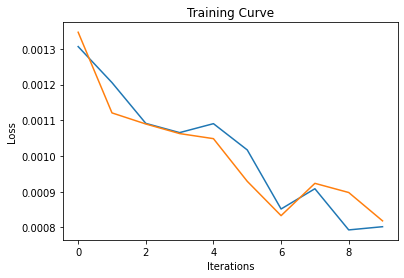

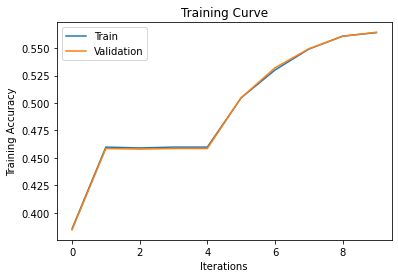

Final Training Accuracy: 0.5642420860075031
Final Validation Accuracy: 0.5645616319444444


In [103]:
model = AutoEncoder()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
#batch_size: 64, num_epochs: 10, lr: 0.0008
train(model,train_loader,valid_loader,batch_size=64,num_epochs =10,learning_rate=0.0001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [ ]:
def train_without_curves(model, train_loader,valid_loader,batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
    train_acc = []
    val_acc = []
    iters = []
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss  = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            val_loss = criterion(recon, data)
        
        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)  # average train loss
        val_losses.append(float(val_loss)/batch_size)     # average validation loss
        train_acc.append(get_accuracy(model, train_loader)) # training accuracy 
        val_acc.append(get_accuracy(model, valid_loader))  # validation accuracy
        print("epoch:", epoch+1, "train_accuracy: ", train_acc[epoch], "val_accuracy: ", val_acc[epoch])

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [110]:
autoencoder = AutoEncoder()
# For the first model
# I would increase the num_epochs to 15 to see if the accuracy can have improvement
# batch_size: 64, num_epochs: 15, lr: 0.0001
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
train_without_curves(autoencoder,train_loader,valid_loader,batch_size=64,num_epochs =15,learning_rate=0.0001)

epoch: 1 train_accuracy:  0.38200322450624746 val_accuracy:  0.38230613425925924
epoch: 2 train_accuracy:  0.4592130964561436 val_accuracy:  0.45750144675925924
epoch: 3 train_accuracy:  0.45907357455120457 val_accuracy:  0.4580078125
epoch: 4 train_accuracy:  0.4583914674603913 val_accuracy:  0.45609085648148145
epoch: 5 train_accuracy:  0.4597556816420178 val_accuracy:  0.4584418402777778
epoch: 6 train_accuracy:  0.46033702291259726 val_accuracy:  0.45883969907407407
epoch: 7 train_accuracy:  0.46872383964282394 val_accuracy:  0.4675925925925926
epoch: 8 train_accuracy:  0.5298499364400211 val_accuracy:  0.5314308449074074
epoch: 9 train_accuracy:  0.5369500511580318 val_accuracy:  0.5372540509259259
epoch: 10 train_accuracy:  0.5549716305459957 val_accuracy:  0.5558449074074074
epoch: 11 train_accuracy:  0.5721405760704431 val_accuracy:  0.5717954282407407
epoch: 12 train_accuracy:  0.5740473754379437 val_accuracy:  0.5733868634259259
epoch: 13 train_accuracy:  0.5790624127988094 v

In [111]:
autoencoder2 = AutoEncoder()
# For the second model, since the accuracy improve in model 1 
# I would keep the num_eopch and increase the batch size to 128 to see the accuracy.
# batch_size: 128, num_epochs: 15, lr: 0.0001
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, shuffle=True)
train_without_curves(autoencoder2,train_loader,valid_loader,batch_size=128,num_epochs =15,learning_rate=0.0001)

epoch: 1 train_accuracy:  0.392583635630794 val_accuracy:  0.3917100694444444
epoch: 2 train_accuracy:  0.4598486962453105 val_accuracy:  0.4585503472222222
epoch: 3 train_accuracy:  0.4598486962453105 val_accuracy:  0.4585503472222222
epoch: 4 train_accuracy:  0.46527454810405233 val_accuracy:  0.4635416666666667
epoch: 5 train_accuracy:  0.4638328217530152 val_accuracy:  0.46242042824074076
epoch: 6 train_accuracy:  0.47374662822063063 val_accuracy:  0.4718605324074074
epoch: 7 train_accuracy:  0.521408861191207 val_accuracy:  0.5209418402777778
epoch: 8 train_accuracy:  0.5530183238768487 val_accuracy:  0.5538194444444444
epoch: 9 train_accuracy:  0.5634204570117508 val_accuracy:  0.5647786458333334
epoch: 10 train_accuracy:  0.5662186463274734 val_accuracy:  0.5665509259259259
epoch: 11 train_accuracy:  0.5710166496139893 val_accuracy:  0.5716507523148148
epoch: 12 train_accuracy:  0.5699624841100053 val_accuracy:  0.5703848379629629
epoch: 13 train_accuracy:  0.5732722537438378 va

In [115]:
autoencoder3 = AutoEncoder()
# For the third model, since the accuracy in model 1 and 2 increase compared with the the original model, but not so much
# I would change back the batch_size and num_eopchs and then improve learning rate to see the effect and
# batch_size: 64, num_epochs: 10, lr: 0.0008
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
train_without_curves(autoencoder3,train_loader,valid_loader,batch_size=64,num_epochs =10,learning_rate=0.0008)

epoch: 1 train_accuracy:  0.4598486962453105 val_accuracy:  0.4585503472222222
epoch: 2 train_accuracy:  0.5628933742597588 val_accuracy:  0.5623914930555556
epoch: 3 train_accuracy:  0.5791786810529254 val_accuracy:  0.5782335069444444
epoch: 4 train_accuracy:  0.5871081759836294 val_accuracy:  0.5851417824074074
epoch: 5 train_accuracy:  0.5996651474281463 val_accuracy:  0.5983434606481481
epoch: 6 train_accuracy:  0.5945028369454004 val_accuracy:  0.5911820023148148
epoch: 7 train_accuracy:  0.6028741512417449 val_accuracy:  0.6003689236111112
epoch: 8 train_accuracy:  0.5968979629801879 val_accuracy:  0.5910011574074074
epoch: 9 train_accuracy:  0.6025873562149258 val_accuracy:  0.5966796875
epoch: 10 train_accuracy:  0.6050522432021828 val_accuracy:  0.599609375
Final Training Accuracy: 0.6050522432021828
Final Validation Accuracy: 0.599609375


In [113]:
autoencoder4 = AutoEncoder()
# For the last model, since the accuracy in model 3 improve better than accuracy in model 1 and 2
# I want to try larger learning rate
# batch_size: 64, num_epochs: 10, lr: 0.001
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
train_without_curves(autoencoder4,train_loader,valid_loader,batch_size=64,num_epochs =10,learning_rate=0.001)

epoch: 1 train_accuracy:  0.5468716088425883 val_accuracy:  0.5476707175925926
epoch: 2 train_accuracy:  0.5736365609400675 val_accuracy:  0.5730975115740741
epoch: 3 train_accuracy:  0.5881933463553778 val_accuracy:  0.5877097800925926
epoch: 4 train_accuracy:  0.5888444485784268 val_accuracy:  0.5871310763888888
epoch: 5 train_accuracy:  0.6030369267975072 val_accuracy:  0.6032624421296297
epoch: 6 train_accuracy:  0.5885809072024308 val_accuracy:  0.5882884837962963
epoch: 7 train_accuracy:  0.5959368120794964 val_accuracy:  0.5927734375
epoch: 8 train_accuracy:  0.5995798840417945 val_accuracy:  0.5942201967592593
epoch: 9 train_accuracy:  0.6092146466995318 val_accuracy:  0.6033347800925926
epoch: 10 train_accuracy:  0.6073853595014417 val_accuracy:  0.6018156828703703
Final Training Accuracy: 0.6073853595014417
Final Validation Accuracy: 0.6018156828703703


## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [116]:
# The best model among 4 models is last model 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
# batch_size: 64, num_epochs: 10, lr: 0.001
test_acc = get_accuracy(autoencoder4, test_loader)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.6055410879629629


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [101]:
most_common_value = {}
for col in df_not_missing.columns:
  most_common_value[col] = df_not_missing[col].value_counts().idxmax()

baseline_acc = sum(df_not_missing["marriage"] == most_common_value["marriage"])/len(df_not_missing)
print("Baseline model accuracy:", baseline_acc) 

Baseline model accuracy: 0.4667947131974738


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

My model from part (a) performs much better than the baseline model in part(b) by comparing the test accuracies in both models.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [118]:
get_features(test_dataset[0])


{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

It is reasonable to guess the person's education level based on work,occupation and edu because these can reflect person's education background. However, marriage, sex, and relationship does not say much about the person's education level.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [121]:
best_model_person = torch.from_numpy(test_dataset[0])
prediction = autoencoder4(best_model_person)
prediction = prediction.detach().numpy()
print("My model's prediction:", get_feature(prediction, "edu"))
# My model's prediction of this person's education level is Masters.

My model's prediction: Masters


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [123]:
print("baseline model's prediction:", most_common_value["edu"])
# baseline model's prediction of this person's education level is HS-grad.

baseline model's prediction:  HS-grad
